### Описание решения

#### 1. **Исследование данных (EDA)**  
- В ходе анализа данных был выявлен явный дисбаланс классов, где один из классов был представлен значительно меньшим числом примеров.  
- Пропусков в данных не было.  
- Были добавлены дополнительные признаки:
  - Количество слов в твите.
  - Количество символов в твите.
  - **Тональность твита**, рассчитанная с помощью предобученной модели **rubert-base-cased-sentiment**, так как более лёгкие модели (TextBlob и Vader) показывали низкую точность классификации.  

#### 2. **Нормализация и эмбединги текста**
- Для нормализации и лемматизации текста использовались библиотеки **pymorphy2** и **nltk**
- Для токенизации **word_tokenize**  
- Для представления текстовых данных использовались **fastText эмбединги размерностью 300**.  

#### 3. **Борьба с дисбалансом классов**  
- Для борьбы с дисбалансом классов использовался метод **SMOTE (Synthetic Minority Over-sampling Technique)**, чтобы увеличить количество примеров меньшего класса, генерируя новые точки на основе соседей в пространстве признаков.  
- SMOTE применялся только для **Random Forest**, но не для **LSTM**, так как LSTM имеет встроенные механизмы работы с дисбалансом при использовании `sample_weight`.

#### 4. **Модель Random Forest**  
- Для обучения была выбрана модель **Random Forest**.  
- С помощью **кросс-валидации** были найдены **оптимальные гиперпараметры**

#### 5. **Модель LSTM**  
- Также была использована модель **LSTM** для сравнения.  
- Архитектура модели: 
  - Эмбединги текста подавались на два последовательных слоя LSTM.
  - Дополнительные признаки (количество слов, символов и тональность) подавались в Dense-слой отдельно и затем объединялись с выходом LSTM.
  - Финальный слой с сигмоидной активацией выполнял бинарную классификацию.
- Для борьбы с дисбалансом использовался `sample_weight`, который давал больший вес примерам класса меньшинства.  
- Для улучшения результатов LSTM:
  - Добавлен дополнительный полносвязный слой.
  - Увеличено количество эпох обучения с использованием **Early Stopping** для предотвращения переобучения.

#### 6. **Сравнение результатов**  
- Несмотря на доработки LSTM, **Random Forest** показал лучшие результаты:  
  - Более высокая F1-метрика.
  - Лучшая интерпретируемость и стабильность результатов.  

#### 7. **Финальное обучение**  
- Для финальной версии модели тренировочная выборка (`train`) и валидационная выборка (`val`) были объединены.  
- Обучение Random Forest выполнялось на объединённых данных с оптимальными гиперпараметрами, найденными с помощью кросс-валидации.  


In [27]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/kfu-hw-1-classification-2024/test.tsv
/kaggle/input/kfu-hw-1-classification-2024/train.tsv


In [28]:
!pip install pymorphy2

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import download
import pymorphy2
from transformers import pipeline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
import fasttext
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout, Concatenate
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score


In [29]:
test_data = pd.read_csv('/kaggle/input/kfu-hw-1-classification-2024/test.tsv')
train_data = pd.read_csv('/kaggle/input/kfu-hw-1-classification-2024/train.tsv')

train_data.head()

,id,tweet,class
0,760402871867367424,"Настало время для ингаляторов. Дружок, Сальбут...",0
1,1035908416869462016,15) На прошлой зимней олимпиаде большинство лы...,1
2,1089839736427032577,Не соглашусь с заменой ЗОК на метопролол в так...,0
3,779671488748224513,"@di2m1 мезим Смекта Если отравление, то лоперамид",0
4,738309299756240897,Уберите микроволновки и имодиум Действуют соу...,0


**EDA**

In [30]:
train_data['class'].value_counts()

class
0    8683
1     832
Name: count, dtype: int64

In [31]:
print(train_data.isnull().sum())
print(test_data.isnull().sum())

id       0
tweet    0
class    0
dtype: int64
id       0
tweet    0
dtype: int64


In [32]:
print(train_data['tweet'].duplicated().sum())

1


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

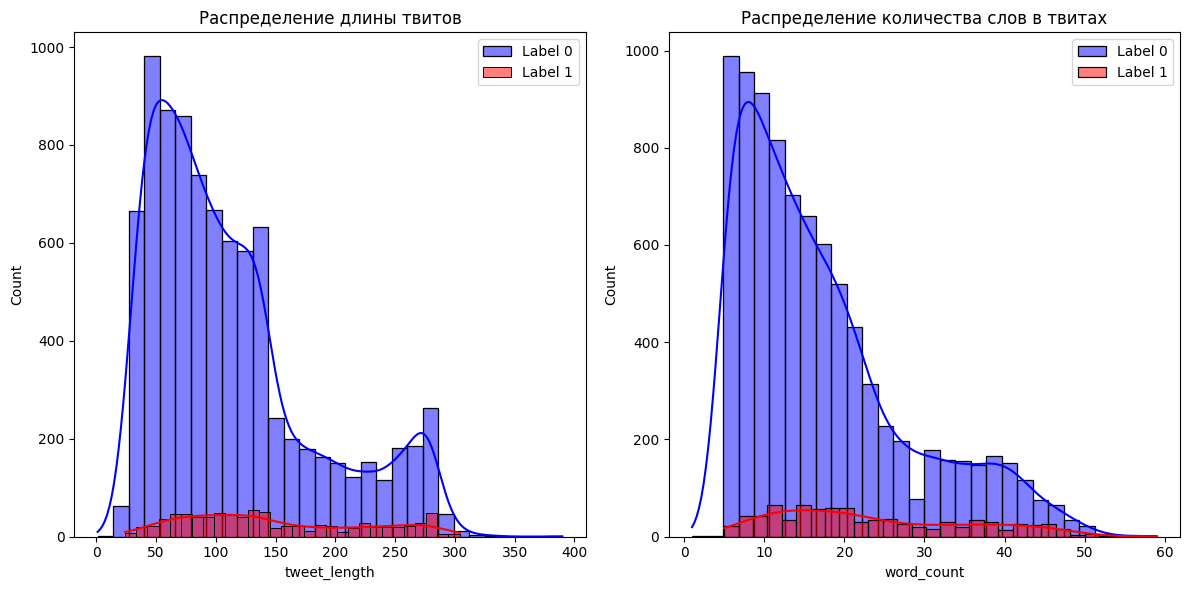

In [33]:
# Анализ зависимости между длинной твита и целевой меткой

train_data['tweet_length'] = train_data['tweet'].apply(len)
train_data['word_count'] = train_data['tweet'].apply(lambda x: len(x.split()))
test_data['tweet_length'] = test_data['tweet'].apply(len)
test_data['word_count'] = test_data['tweet'].apply(lambda x: len(x.split()))



plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(train_data[train_data['class'] == 0]['tweet_length'], kde=True, color='blue', label='Label 0', bins=30)
sns.histplot(train_data[train_data['class'] == 1]['tweet_length'], kde=True, color='red', label='Label 1', bins=30)
plt.title("Распределение длины твитов")
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(train_data[train_data['class'] == 0]['word_count'], kde=True, color='blue', label='Label 0', bins=30)
sns.histplot(train_data[train_data['class'] == 1]['word_count'], kde=True, color='red', label='Label 1', bins=30)
plt.title("Распределение количества слов в твитах")
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
# Разделение на валидационную и тренировочную выборки
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['class'], random_state=42)

**Feature Engineering**

In [35]:
!pip install spacy
!python -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 53.6 MB/s eta 0:00:00:00:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [36]:
# Нормализация текста 

download('stopwords')
download('punkt')

stop_words = set(stopwords.words('russian'))
morph = pymorphy2.MorphAnalyzer()

def preprocess_text(text): # Разбиение на токены и лемматизация
    tokens = word_tokenize(text.lower())
    tokens = [morph.parse(token)[0].normal_form for token in tokens if token.isalnum() and token not in stop_words]
    return ' '.join(tokens)

train_data['cleaned_tweet'] = train_data['tweet'].apply(preprocess_text)
test_data['cleaned_tweet'] = test_data['tweet'].apply(preprocess_text)
val_data['cleaned_tweet'] = val_data['tweet'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [38]:
# Анализ тональности

classifier = pipeline("sentiment-analysis", model="blanchefort/rubert-base-cased-sentiment")

def analyze_sentiment(text):
    result = classifier(text)[0]  
    return result['label'], result['score']  

train_data[['sentiment_label', 'sentiment_score']] = train_data['cleaned_tweet'].apply(
    lambda x: pd.Series(analyze_sentiment(x))
)

test_data[['sentiment_label', 'sentiment_score']] = test_data['cleaned_tweet'].apply(
    lambda x: pd.Series(analyze_sentiment(x))
)

val_data[['sentiment_label', 'sentiment_score']] = val_data['cleaned_tweet'].apply(
    lambda x: pd.Series(analyze_sentiment(x))
)


Device set to use cpu


Топ-20 слов: [('это', 1102), ('ксанакс', 1070), ('прозак', 712), ('флуоксетин', 603), ('таблетка', 450), ('пить', 429), ('день', 419), ('флуоксетина', 355), ('который', 335), ('препарат', 331), ('такой', 318), ('ещё', 315), ('лоперамид', 311), ('сальбутамол', 311), ('год', 309), ('паксила', 302), ('тамифить', 298), ('просто', 293), ('очень', 270), ('рецепт', 256)]


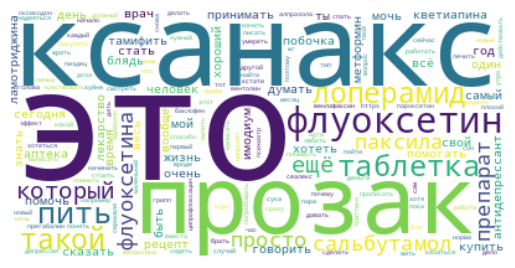

In [39]:
# Вывод самых используемых слов

def get_top_n_words(corpus, n=None):
    words = ' '.join(corpus).split()
    return Counter(words).most_common(n)

all_tweets = train_data['cleaned_tweet']
top_words = get_top_n_words(all_tweets, n=20)
print("Топ-20 слов:", top_words)

wordcloud = WordCloud(background_color='white').generate(' '.join(all_tweets))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [40]:
train_data.head()

,id,tweet,class,tweet_length,word_count,cleaned_tweet,sentiment_label,sentiment_score
7228,1150716954623299589,"вообще пить таблетки без рецепта ну такое, там...",0,280,49,вообще пить таблетка рецепт такой наверное инд...,NEGATIVE,0.751548
6648,1100682624065064960,Спасибо мирозданию за вентолин. Я хз уже че де...,0,244,40,спасибо мироздание вентолин хз че делать свой ...,POSITIVE,0.637986
281,952559719339712512,мне бы кто из паксила сделал,0,28,6,паксила сделать,NEUTRAL,0.828173
7260,824477611480981508,"за неимением шарфов дышу через пуховой платок,...",0,106,17,неимение шарф дышать пуховый платок плюс венто...,NEUTRAL,0.768095
4491,656520931679055872,"Харьковские телки под баклофеном , через 10 ми...",0,137,21,харьковский тёлка баклофен 10 минута присоедин...,NEUTRAL,0.819142


In [41]:
train_data['sentiment_label'].value_counts()

sentiment_label
NEUTRAL     4014
NEGATIVE    2917
POSITIVE     681
Name: count, dtype: int64

In [42]:
print(train_data.describe())
print(test_data.describe())

             class  tweet_length   word_count  sentiment_score
count  7612.000000   7612.000000  7612.000000      7612.000000
mean      0.087493    115.430636    17.776012         0.785046
std       0.282575     69.655949    10.866814         0.075934
min       0.000000     20.000000     4.000000         0.341355
25%       0.000000     61.000000     9.000000         0.751495
50%       0.000000     98.000000    15.000000         0.796436
75%       0.000000    143.000000    23.000000         0.825434
max       1.000000    390.000000    59.000000         0.994892
       tweet_length   word_count  sentiment_score
count   1504.000000  1504.000000      1504.000000
mean     126.934840    19.541888         0.783576
std       72.732101    11.343466         0.080067
min       22.000000     5.000000         0.372410
25%       70.000000    11.000000         0.751478
50%      107.000000    16.000000         0.755613
75%      170.000000    26.000000         0.825128
max      283.000000    58.000000 

In [44]:
train_data.head(3)

,id,tweet,class,tweet_length,word_count,cleaned_tweet,sentiment_label,sentiment_score
7228,1150716954623299589,"вообще пить таблетки без рецепта ну такое, там...",0,280,49,вообще пить таблетка рецепт такой наверное инд...,NEGATIVE,0.751548
6648,1100682624065064960,Спасибо мирозданию за вентолин. Я хз уже че де...,0,244,40,спасибо мироздание вентолин хз че делать свой ...,POSITIVE,0.637986
281,952559719339712512,мне бы кто из паксила сделал,0,28,6,паксила сделать,NEUTRAL,0.828173


In [45]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.bin.gz
!gzip -d cc.ru.300.bin.gz

--2025-01-26 15:59:58--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.33, 13.227.219.10, 13.227.219.59, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4496459151 (4.2G) [application/octet-stream]
Saving to: ‘cc.ru.300.bin.gz’

cc.ru.300.bin.gz    100%[===================>]   4.19G   192MB/s    in 21s     

2025-01-26 16:00:19 (204 MB/s) - ‘cc.ru.300.bin.gz’ saved [4496459151/4496459151]

gzip: cc.ru.300.bin already exists; do you wish to overwrite (y or n)? ^C


In [46]:
ft = fasttext.load_model('cc.ru.300.bin')


def get_fasttext_embeddings(texts):
    return [ft.get_sentence_vector(text) for text in texts]

# Создаем эмбединги
X_train_text_fasttext = np.array(get_fasttext_embeddings(train_data['cleaned_tweet']))
X_val_text_fasttext = np.array(get_fasttext_embeddings(val_data['cleaned_tweet']))


additional_features_train = train_data[['tweet_length', 'word_count', 'sentiment_score']].values
additional_features_val = val_data[['tweet_length', 'word_count', 'sentiment_score']].values

# Объединение эмбеддингов и дополнительных признаков
X_train = np.hstack([X_train_text_fasttext, additional_features_train])
X_val = np.hstack([X_val_text_fasttext, additional_features_val])


# Генерация искусственных сэмплов
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, train_data['class'])

# Обучение модели
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train_resampled, y_train_resampled)


predictions = model.predict(X_val)
pred_proba = model.predict_proba(X_val)[:, 1]


print("Classification Report:")
print(classification_report(val_data['class'], predictions))
print("Confusion Matrix:")
print(confusion_matrix(val_data['class'], predictions))
print("ROC-AUC Score:", roc_auc_score(val_data['class'], pred_proba))


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1737
           1       0.41      0.34      0.37       166

    accuracy                           0.90      1903
   macro avg       0.68      0.65      0.66      1903
weighted avg       0.89      0.90      0.90      1903

Confusion Matrix:
[[1658   79]
 [ 110   56]]
ROC-AUC Score: 0.8286669996046362


In [47]:
from sklearn.model_selection import cross_val_score, GridSearchCV


# Кросс валидация для поиска лучших параметров
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [75, 125],
    'max_depth': [3, 5, 7],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='f1', n_jobs=-1, verbose=2)
grid_rf.fit(X_train_resampled, y_train_resampled)

best_rf = grid_rf.best_estimator_
best_rf

Fitting 5 folds for each of 48 candidates, totalling 240 fits


RandomForestClassifier(max_depth=7, min_samples_leaf=5, min_samples_split=10,
                       n_estimators=125, random_state=42)

In [49]:
y_pred_rf = best_rf.predict(X_val)
pred_proba_rf = best_rf.predict_proba(X_val)[:, 1]

y_pred_train_rf = best_rf.predict(X_train)
pred_proba_train_rf = best_rf.predict_proba(X_train)[:, 1]


print("Classification Report Random Forest on Train:")
print(classification_report(train_data['class'], y_pred_train_rf))

print("Confusion Matrix on Train:")
print("Random Forest:")
print(confusion_matrix(train_data['class'], y_pred_train_rf))

print("ROC-AUC Score for Random Forest on Train:", roc_auc_score(train_data['class'], pred_proba_train_rf))

print("\nClassification Report Random Forest on Validation:")
print(classification_report(val_data['class'], y_pred_rf))


print("Confusion Matrix on Validation:")
print("Random Forest:")
print(confusion_matrix(val_data['class'], y_pred_rf))

print("ROC-AUC Score for Random Forest on Validation:", roc_auc_score(val_data['class'], pred_proba_rf))

# Оценка на train и validation указывает на небольшое переобучение

Classification Report Random Forest on Train:
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      6946
           1       0.39      0.93      0.55       666

    accuracy                           0.87      7612
   macro avg       0.69      0.90      0.74      7612
weighted avg       0.94      0.87      0.89      7612

Confusion Matrix on Train:
Random Forest:
[[5979  967]
 [  44  622]]
ROC-AUC Score for Random Forest on Train: 0.9528875261671116

Classification Report Random Forest on Validation:
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      1737
           1       0.28      0.67      0.40       166

    accuracy                           0.82      1903
   macro avg       0.62      0.75      0.65      1903
weighted avg       0.90      0.82      0.85      1903

Confusion Matrix on Validation:
Random Forest:
[[1450  287]
 [  54  112]]
ROC-AUC Score for Random Forest on Validatio

In [68]:
# Перевод в эмбединги для подачи в модель LSTM
def get_fasttext_word_embeddings(texts, max_sequence_length):
    embeddings = []
    for text in texts:
        
        words = text.split()
        word_embeddings = [ft.get_word_vector(word) for word in words[:max_sequence_length]]
        while len(word_embeddings) < max_sequence_length:
            word_embeddings.append(np.zeros(300)) # Твиты меньшой длины заполняем 0
        embeddings.append(word_embeddings)
    return np.array(embeddings)


max_sequence_length = 50  # Максимальная длина твита в словах
X_train_text_fasttext = get_fasttext_word_embeddings(train_data['cleaned_tweet'], max_sequence_length)
X_val_text_fasttext = get_fasttext_word_embeddings(val_data['cleaned_tweet'], max_sequence_length)
X_test_text_fasttext = get_fasttext_word_embeddings(test_data['cleaned_tweet'], max_sequence_length)


In [52]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout, Concatenate
from keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

train_data['class'] = train_data['class'].astype(int)
val_data['class'] = val_data['class'].astype(int)

# Считаем веса чтобы сбалансировать модель
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(train_data['class']), 
    y=train_data['class']
)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}  # {0: 0.5, 1: 5.7}

sample_weights = train_data['class'].map(class_weights_dict).values

text_input = Input(shape=(X_train_text_fasttext.shape[1], X_train_text_fasttext.shape[2]), name='Text_Input') 
lstm_layer = LSTM(64, return_sequences=True)(text_input)
lstm_layer = Dropout(0.2)(lstm_layer)
lstm_output = LSTM(32)(lstm_layer)

additional_input = Input(shape=(additional_features_train.shape[1],), name='Additional_Input')
dense_additional = Dense(32, activation='relu')(additional_input) # Добавляем дополнительные параметры

merged = Concatenate()([lstm_output, dense_additional])
dense_layer = Dense(64, activation='relu')(merged)

dense_layer2 = Dense(32, activation='relu')(dense_layer)


output = Dense(1, activation='sigmoid')(dense_layer2)

model = Model(inputs=[text_input, additional_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['precision', 'recall'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


model.fit(
    [X_train_text_fasttext, additional_features_train],
    train_data['class'],
    sample_weight=sample_weights,
    epochs=20,
    batch_size=32,
    validation_data=([X_val_text_fasttext, additional_features_val], val_data['class']),
    callbacks=[early_stopping]  
)

Train classes: [0 1]
Validation classes: [0 1]
Epoch 1/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - loss: 0.8261 - precision: 0.1025 - recall: 0.5862 - val_loss: 0.6474 - val_precision: 0.1900 - val_recall: 0.5723
Epoch 2/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - loss: 0.6302 - precision: 0.1612 - recall: 0.6961 - val_loss: 0.7483 - val_precision: 0.1484 - val_recall: 0.9036
Epoch 3/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 0.5917 - precision: 0.1947 - recall: 0.7569 - val_loss: 0.5930 - val_precision: 0.2220 - val_recall: 0.6807
Epoch 4/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - loss: 0.5697 - precision: 0.2049 - recall: 0.7563 - val_loss: 0.6266 - val_precision: 0.1951 - val_recall: 0.9096
Epoch 5/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - loss: 0.5637 - precision: 0.2057 - recall: 0.7763 - val_loss: 0.8105 - val_precision: 0.1595 - val_recall: 0.9398
Epoch 6/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - loss: 0.5486 - precision: 0.2105 - recall: 0.79

In [53]:

y_pred_val = model.predict([X_val_text_fasttext, additional_features_val])
y_pred_train = model.predict([X_train_text_fasttext, additional_features_train])
y_pred_val_labels = (y_pred_val > 0.5).astype(int) # Избалвяемся от вероятностей
y_pred_train_labels = (y_pred_train > 0.5).astype(int)
f1_val = f1_score(val_data['class'], y_pred_val_labels)
f1_train = f1_score(train_data['class'], y_pred_train_labels)

print(f"F1-метрика на выборках:", f1_train, f1_val)
print(confusion_matrix(val_data['class'], y_pred_val_labels))
print(confusion_matrix(train_data['class'], y_pred_train_labels))
print('ROC-AUC train', roc_auc_score(train_data['class'], y_pred_train_labels))
print('ROC-AUC val', roc_auc_score(val_data['class'], y_pred_val_labels))


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
F1-метрика на выборках: 0.37545922116091107 0.35807860262008734
[[1339  398]
 [  43  123]]
[[5401 1545]
 [ 155  511]]
ROC-AUC train 0.7724185458133055
ROC-AUC val 0.7559165851662262


In [55]:
# Подготавливаем данные для сабмита
asttext = np.array(get_fasttext_embeddings(test_data['cleaned_tweet']))

additional_features_test = test_data[['tweet_length', 'word_count', 'sentiment_score']].values

X_test = np.hstack([X_test_text_fasttext, additional_features_test])



In [73]:
# Объединяем выборки для обучения
X_combined = np.vstack([X_train_resampled, X_val])
y_combined = np.hstack([y_train_resampled, val_data['class'].values])


best_params = grid_rf.best_params_

best_rf = RandomForestClassifier(
    **best_params,
    random_state=42
)

best_rf.fit(X_combined, y_combined)

RandomForestClassifier(max_depth=7, min_samples_leaf=5, min_samples_split=10,
                       n_estimators=125, random_state=42)

In [75]:
y_pred_test_rf = best_rf.predict(X_test)
# y_pred_test_lstm = model.predict([X_test_text_fasttext, additional_features_test])
# y_pred_test_labels = (y_pred_test_lstm > 0.5).astype(int).flatten()

results = pd.DataFrame({
    'id': test_data['id'], 
    'class': y_pred_test_rf   
})

results.to_csv('submission.csv', index=False)